In [93]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reliability.Fitters import Fit_Weibull_2P
from cycler import cycler
plt.style.use('ggplot')
palette = ["#00B0F6", "#F8766D", "#00BF7D", "#A3A500", "#E76BF3"]
plt.rc('axes', prop_cycle=(cycler('color', palette)))
from scipy.stats import exponweib
import arviz as az

In [94]:
def fit_uninformed_model(data, p=None):

    if p is None:

        p = {
            'alpha': [1, 25],
            'beta': [1, 2000]
        }

    with pm.Model() as model:
        # weibull modulus
        alpha = pm.Uniform('alpha', lower=p['alpha'][0], upper=p['alpha'][1])

        # characteristic strength
        beta = pm.Uniform('beta', lower=p['beta'][0], upper=p['beta'][1])
        
        # likelihood
        y_obs =  pm.Weibull('y', alpha=alpha, beta=beta, observed=data)

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(tune=5000, draws=5000, target_accept=0.95))
        idata.extend(pm.sample_posterior_predictive(idata))

    return idata, model

def fit_informed_model(data, p=None):

    if p is None:
        p = {
            'alpha': [8, 2.5], # mu, sigma
            'beta': [800, 150] # mu, sigma
        }

    with pm.Model() as model:
        # weibull modulus
        alpha = pm.TruncatedNormal('alpha', mu=p['alpha'][0], sigma=p['alpha'][1], lower=0.0)

        # characteristic strength
        beta = pm.TruncatedNormal('beta', mu=p['beta'][0], sigma=p['beta'][1], lower=0.0)
        
        # likelihood
        y_obs =  pm.Weibull('y', alpha=alpha, beta=beta, observed=data)

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(tune=5000, draws=5000))
        idata.extend(pm.sample_posterior_predictive(idata))

    return idata, model


In [95]:
data = pd.read_csv('data/batch_3_strengths.csv', header=None)[0].values

### Fit the Uninformed Model to the Data

Sampling: [alpha, beta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 4 seconds.
Sampling: [y]


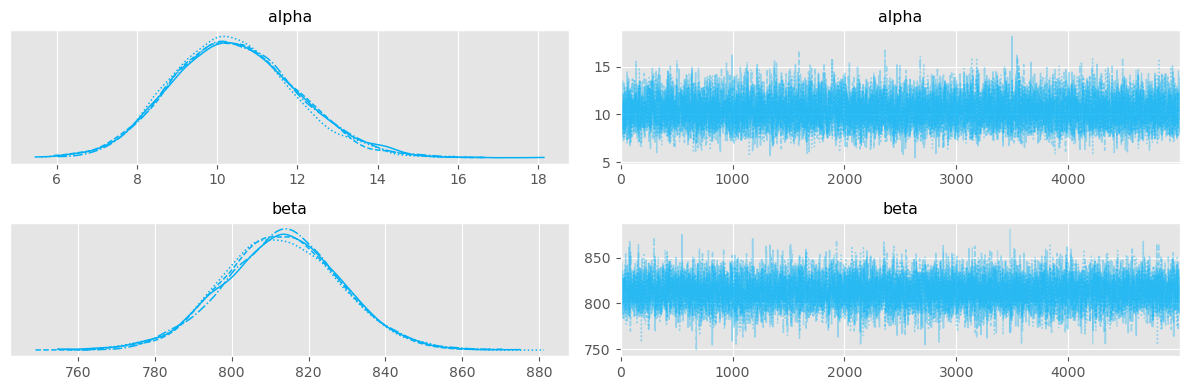

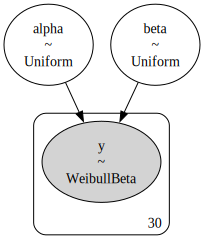

In [96]:
uninformed_trace, uninformed_model = fit_uninformed_model(data)

az.plot_trace(uninformed_trace, var_names=("alpha", "beta"))
plt.tight_layout()
plt.show()

az.summary(uninformed_trace, round_to=2, kind='stats')

pm.model_to_graphviz(uninformed_model)

### Fit the Informed Model to the Data

Sampling: [alpha, beta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 3 seconds.
Sampling: [y]


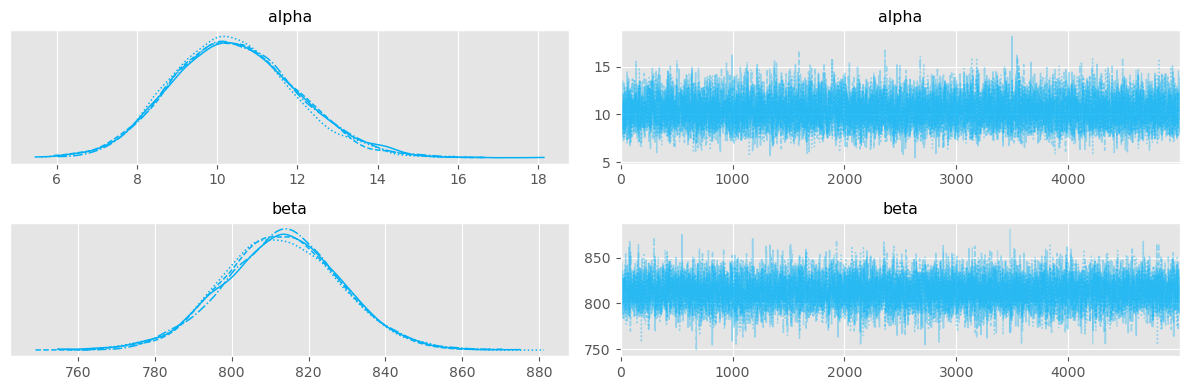

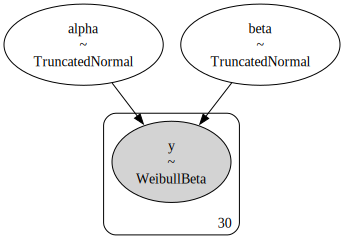

In [97]:
informed_trace, informed_model = fit_informed_model(data)

az.plot_trace(uninformed_trace, var_names=("alpha", "beta"))
plt.tight_layout()
plt.show()

az.summary(informed_trace, round_to=2, kind='stats')

pm.model_to_graphviz(informed_model)

### Fit the MLE Model to the Data

In [98]:
fit = Fit_Weibull_2P(failures=data, show_probability_plot=False, print_results=False)
print(dir(fit))
print("alpha", fit.alpha)
print("alpha SE", fit.alpha_SE)
print("alpha CI", fit.alpha_lower, fit.alpha_upper)

print("\nbeta", fit.beta)
print("beta SE", fit.beta_SE)
print("beta CI", fit.beta_lower, fit.beta_upper)

['AD', 'AICc', 'BIC', 'Cov_alpha_beta', 'LL', 'LL_fb', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'alpha', 'alpha_SE', 'alpha_lower', 'alpha_upper', 'beta', 'beta_SE', 'beta_lower', 'beta_upper', 'distribution', 'gamma', 'goodness_of_fit', 'logR', 'logf', 'loglik', 'loglik2', 'method', 'optimizer', 'results']
alpha 811.3789427643976
alpha SE 14.936545140169772
alpha CI 782.6256896747379 841.1885751349133

beta 10.421439102910828
beta SE 1.5549564891618382
beta CI 7.778969565346437 13.961539772503537


### Code for Esimating 5% Failure Strength

In [99]:
# let's get the A,B basis estimates
def ecdf(sample):
    # convert sample to a numpy array, if it isn't already
    sample = np.atleast_1d(sample)

    # find the unique values and their corresponding counts
    quantiles, counts = np.unique(sample, return_counts=True)

    # take the cumulative sum of the counts and divide by the sample size to
    # get the cumulative probabilities between 0 and 1
    cumprob = np.cumsum(counts).astype(np.double) / sample.size
    return quantiles, cumprob

num_samples = 1000
alphas = az.extract(informed_trace, num_samples=num_samples, var_names=("alpha"))
betas = az.extract(informed_trace, num_samples=num_samples, var_names=("beta"))

hist_data = []
for i in range(num_samples):
    draws = pm.draw(
        pm.Weibull.dist(alpha=alphas[i].values, beta=betas[i].values),
        1000
    )
    qe, pe = ecdf(draws)
    lkup = dict(zip(pe, qe))
    hist_data.append([lkup[0.05]])

five_prc_CI = az.hdi(np.array(hist_data), hdi_prob=0.9)[0]
five_prc_mean = np.mean(hist_data)


/var/folders/mr/t_bgg1cx77d83fh1txvc1j1r0000gn/T/ipykernel_9364/2766717321.py:28: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  five_prc_CI = az.hdi(np.array(hist_data), hdi_prob=0.9)[0]


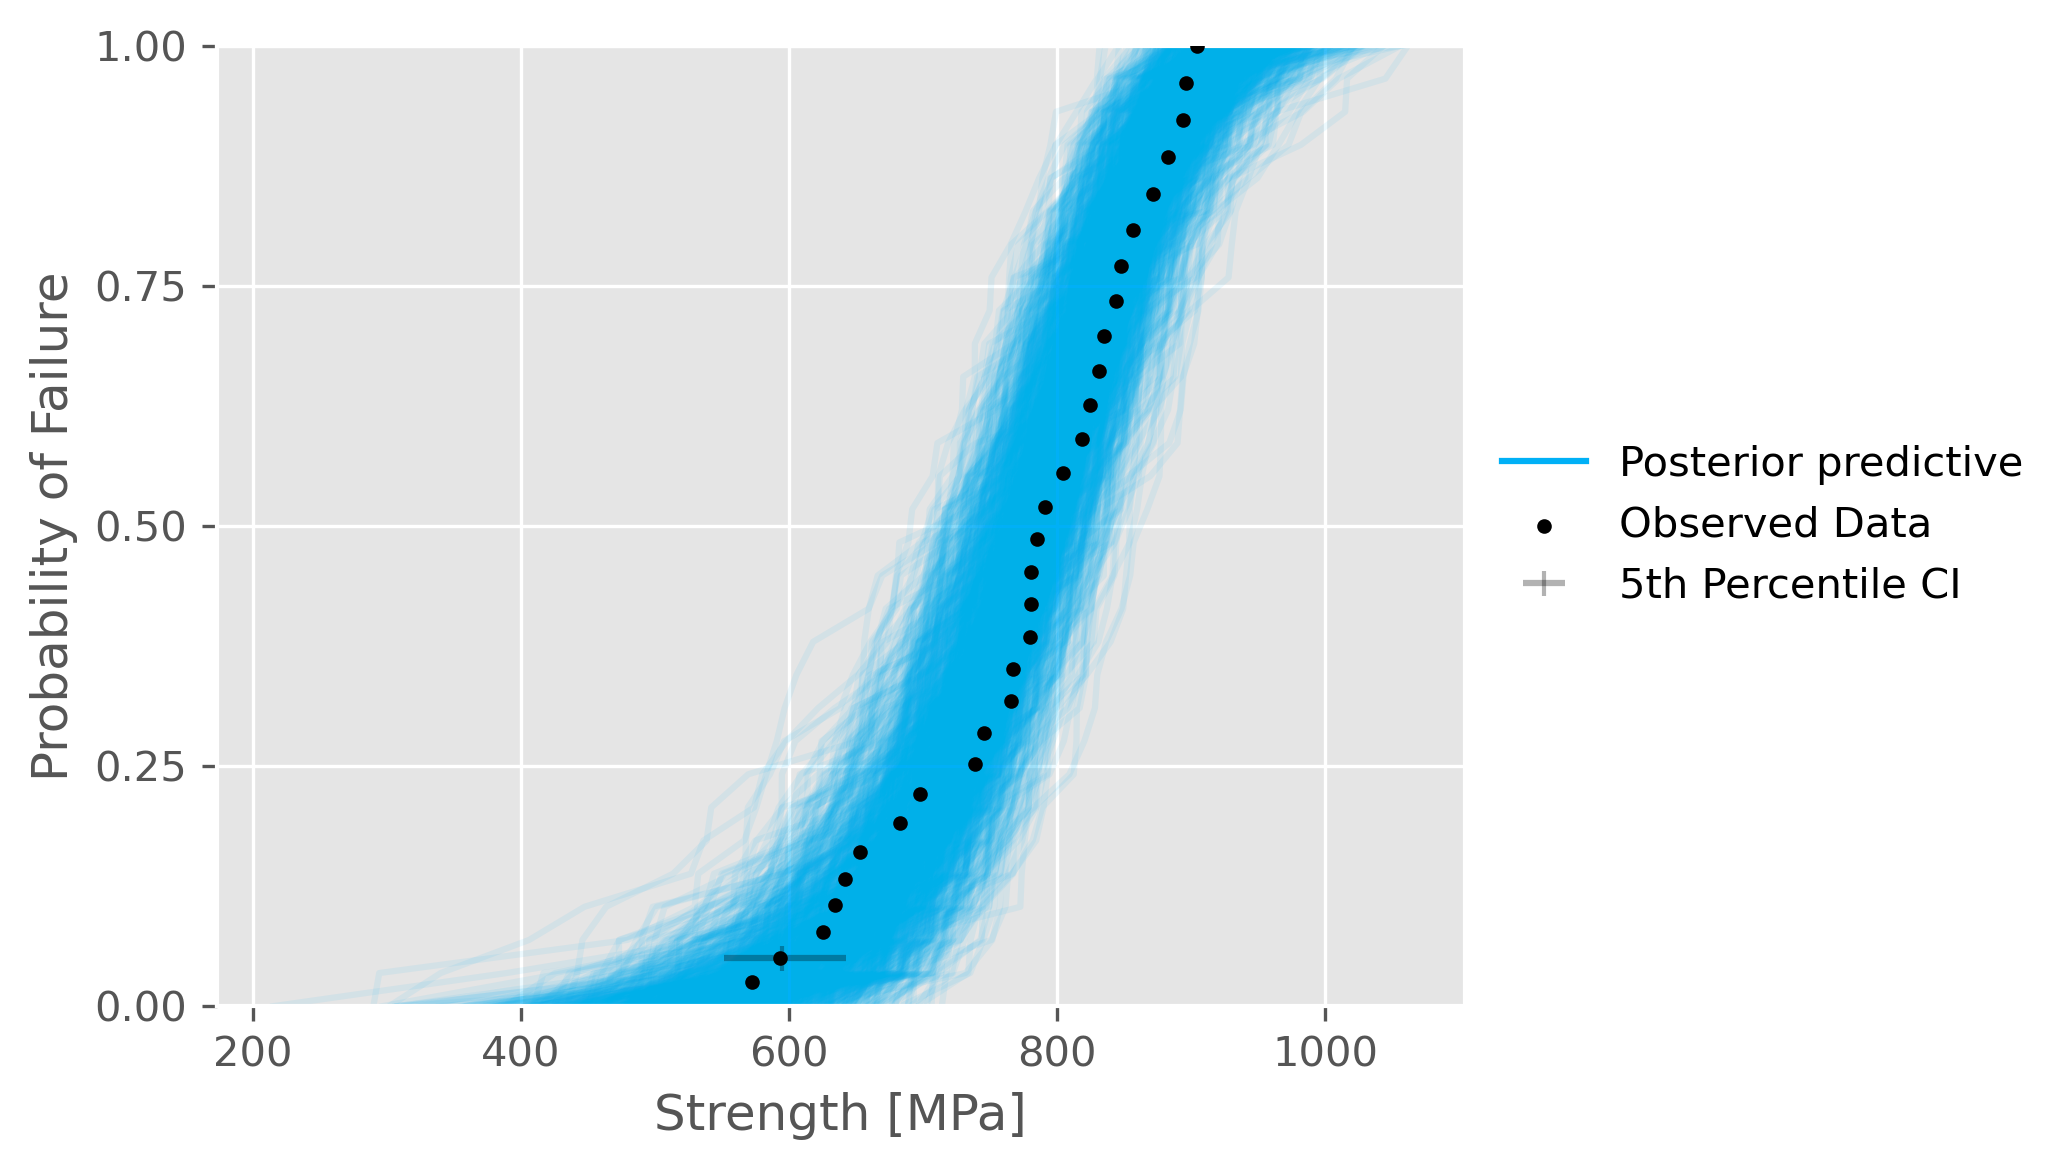

In [100]:
# az.style.use("arviz-doc")
# with az.style.context("arviz-doc", after_reset=True):
fig, ax = plt.subplots(figsize=(7, 4), dpi=300, layout="tight")
az.plot_ppc(informed_trace, num_pp_samples=1000, alpha=0.075, mean=False,
            kind="cumulative", observed=False, ax=ax)

sorted_data = np.sort(data)
cumsum = np.cumsum(sorted_data)
plt.scatter(sorted_data, cumsum/cumsum[-1], marker='.', color='k', zorder=100, label='Observed Data')

plt.errorbar(five_prc_mean, 0.05, xerr=[[five_prc_mean - five_prc_CI[0]], [five_prc_CI[1] - five_prc_mean]], fmt='|', color='k', label='5th Percentile CI', alpha=0.3)

ax.set_yticks([0,0.25, 0.5, 0.75, 1])
ax.set_ylim(0, 1)

ax.set_xlabel('Strength [MPa]', fontsize=12)
ax.set_ylabel('Probability of Failure', fontsize=12)

#set ax x,y label textsize for ylabel and xlabel


plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.show()
